# **Speed Dating**

This notebook presents a study of the data obtained during a speed dating experiment. On a weekly basis between 2002 and 2004, small groups of males and females students from Columbia university were involved weekly in heterosexual speed dating sessions. The data was collected in a survey before, during and after the actual dating session. It can be found [here](https://www.kaggle.com/datasets/annavictoria/speed-dating-experiment). It was the basis of (at least) two papers:
* Raymond Fisman, Sheena S. Iyengar, Emir Kamenica and Itamar Simonson, <em>Gender Differences in Mate Selection: Evidence from a Speed Dating Experiment</em>. The Quarterly Journal of Economics, Vol. 121, No. 2 (May, 2006), pp. 673-697. DOI: [10.1162/qjec.2006.121.2.673](https://doi.org/10.1162/qjec.2006.121.2.673)
* Raymond Fisman, Sheena S. Iyengar, Emir Kamenica and Itamar Simonson, <em>Racial Preferences in Dating</em>. The Review of Economic Studies, Vol. 75, No. 1 (Jan., 2008), pp. 117-132. DOI: [10.1111/j.1467-937X.2007.00465.x](https://doi.org/10.1111/j.1467-937X.2007.00465.x)

Although the articles' titles give us hints on what to look for in this dataset, we will focus on understanding <strong>what makes people interested in each other</strong>. In this context, the retained metric to assess the interest in someone is the dating decision (the *like*, in current terms).

The analysis carried here is divided in three parts. We first load the data, get some insights on their content, and make a first preprocessing. We then provide descriptive statistics about the subjects involved in this experiment: age, race, income, self-assessed interests and attributes, etc. Finally, we delve in the analysis of the dating results: attractiveness, attribute and racial preferences.

THe dataset has 195 features and contains a lot of missing data. Although the response rate was high for the surveys made before and during the dating session, a much lower fraction of the participants answered the followup survey. We therefore limit our study to the results of the speed dating sessions, without considering the followup.

Contents
--------
1. [Loading and preprocessing of the dataset](#loading)
2. [Single-subject data analysis](#subjects)
    1. General statistics
    2. Interests
    3. Attributes
    4. Correlation between self-evaluated and empirical looked-for attributes in partners
3. [Dating results analysis](#dating)
    1. Effect of race on the match probability
    2. Effect of interests affinity on match probability
    3. Expected versus real numbers of matches
    4. Correlation between dating decision ('dec'), partner appreciation ('like') and attributes
    5. Age and income difference between matching partners
    6. Attributes difference associated to positive dating decisions
    7. Primality effect in dating decision
4. [Conclusion and perspectives](#conclusion)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import ttest_1samp


def textstr(data: np.ndarray)-> str:
    """
    Utility function that makes a short summary text (mean, std dev, median)
    to display on figures.
    """
    data = data[~np.isnan(data)]
    text = (f'Mean   : {np.mean(data):.2f}\n'
            f'Std dev : {np.std(data):.2f}'
            f'\nMedian : {np.median(data):.2f}')
    return text

## <a id="loading"></a>Loading and preprocessing the dataset

Before moving on to data analysis, we load and prepare the data.
* The file contains a `\x8e` byte. It should be interpreted as "é" (LATIN SMALL LETTER E WITH ACUTE), corresponding to `mac_roman` encoding.
* The floats in the raw dataset have format `xxx,xxx.xx`, we specify `thousands=',', decimal='.'` to load the values properly

In [2]:
fname = "./Speed+Dating+Data.csv"
df = pd.read_csv(fname, encoding='mac_roman', thousands=',', decimal='.')
df.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


The dataset contains a total of 195 features, that can be categorized as follows:
- Objective information about participants (age, sex, location, etc),
- Subective and self-assessed information from paticipants (attributes, interests),
- Evaluations of dating partners (attributes, etc),
- Results of the dataing experiment.

In the following data analysis, we shall distinguish single-subject data (`'age'`, `'income'`, `'gender'`, etc) and dating data (`'dec'`, `'age_o'`, etc). We first address the case of single-subject data and produce a reduced dataframe which contains only subject-related data.

Subjects are distinguished by their `'iid'`. If for a given `'iid'`, an entry has a single value, then it must pertain to the subject. For instance, for `iid = 1`, the column `'age'` has all its rows with value `21`. Since this is true for all `iid`s, we can deduce that the entry `'age'` pertains to the subject and not to the dating.

In [3]:
# for each iid (participant), unique value => entry pertains to the subject
subject_entries = df.groupby('iid').nunique().max() <= 1
# re-insert iid
subject_entries = pd.concat([pd.Series([True], index=['iid']), subject_entries])
### multiple values => entry pertains to dating
### partner_entries = ~subject_entries

subject_cols = df.columns[subject_entries]
subject_df = df[subject_cols].groupby('iid').aggregate(lambda x: x.iloc[0])
subject_df

,id,gender,idg,condtn,wave,round,age,field,field_cd,undergra,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
iid,,,,,,,,,,,,,,,,,,,,,
1,1.0,0,1,1,1,10,21.0,Law,1.0,NaN,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,2.0,0,3,1,1,10,24.0,law,1.0,NaN,...,7.0,6.0,9.0,9.0,4.0,NaN,NaN,NaN,NaN,NaN
3,3.0,0,5,1,1,10,25.0,Economics,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,0,7,1,1,10,23.0,Law,1.0,NaN,...,6.0,5.0,6.0,8.0,5.0,NaN,NaN,NaN,NaN,NaN
5,5.0,0,9,1,1,10,21.0,Law,1.0,NaN,...,4.0,5.0,10.0,6.0,10.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548,18.0,1,36,2,21,22,30.0,Business,8.0,"University of Cologne, Germany",...,8.0,9.0,9.0,9.0,9.0,8.0,9.0,9.0,9.0,7.0
549,19.0,1,38,2,21,22,28.0,General management/finance,8.0,"LUISS, Rome",...,7.0,9.0,8.0,7.0,8.0,5.0,8.0,8.0,6.0,8.0
550,20.0,1,40,2,21,22,30.0,MBA,8.0,Oxford,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## <a id="single-subject"></a>Single-subject data analysis

We first begin by providing some insights on the participants to these sets of speed-dataing studies. In this section, we will explore the following:
- Age, race and income distributions
- Racial statistics
- The average participant in terms of interests (self assessed)
- The participants attributes, and the differences between self-perception and peer perception
- The difference between what the participants declare looking for in a potential partner and what they empirically look for.


However, the vast amount of features provided force us to limit ourselves to a part of the data. We will therefore ignore:
- Location features (`'from'`, `'zipcode'`). These fields have many distinct values (406 zipcodes for instance), making it difficult to aggregate the values to compute statistics. Moreover they should be converted to geographical coordinates prior to being included in the analysis. These are nevertheless indirectly included in the analysis through the `'income'` feature which we assume shares much of the information brought by the location.
- Studies and career features (`'field'`, `'undergrd'`, `'career'`, `'tuition'`, etc). As above, the `'income'` is a good proxy for all these quantities.
- Attitude towards dating (`'goal'`, `'date'`, `'go_out'`, `'exphappy'`). The answers here are not quantitative, and their relation to attractiveness in dating is unclear. Nevertheles, such questions could be used by researchers to determine which participants are not answering honestly to the questionnaire.
- Dating followup (`'you_call'`, `'them_cal'`, `'date_3'`, `'numdat_3'`, `'num_in_3'`)). Only limited information is available

### General statistics

We begin with general participants statistics.

#### Age, income and SAT score distributions

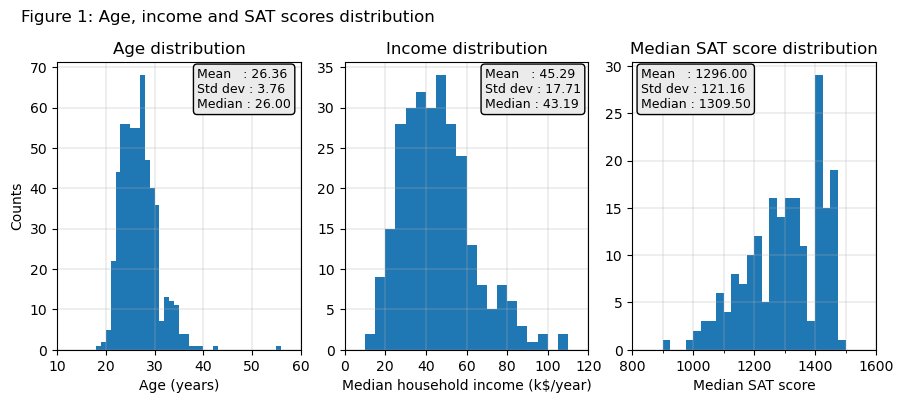

In [4]:
fig1, axs1 = plt.subplots(
    nrows=1, ncols=3, figsize=(9, 4), dpi=100,
    gridspec_kw={'left': 0.06, 'right': 0.97, 'top': 0.85, 'bottom': 0.13, 'wspace': 0.18})
fig1.suptitle('Figure 1: Age, income and SAT scores distribution', x=0.02, ha='left')

for ax in axs1:
    ax.grid(visible=True, linewidth=0.3)
    ax.grid(visible=True, which='minor', linewidth=0.3)
    

axs1[0].set_title("Age distribution")
axs1[0].hist(subject_df['age'], bins=np.linspace(10, 60, 51))
axs1[0].set_xlim(10, 60)
axs1[0].set_xlabel("Age (years)")
axs1[0].set_ylabel('Counts')
axs1[0].text(0.575, 0.84, textstr(subject_df['age'].to_numpy()),
             transform=axs1[0].transAxes, fontsize=9,
             bbox={'boxstyle': 'round', 'facecolor': '0.92'})

axs1[1].set_title("Income distribution")
axs1[1].hist(subject_df['income'], bins=np.linspace(1e4, 1.2e5, 23))
axs1[1].set_xlim(0, 1.2e5)
axs1[1].set_xticks(np.linspace(0, 120000, 7), np.arange(0, 130, 20))
axs1[1].set_xlabel("Median household income (k$/year)")
axs1[1].text(0.575, 0.84, textstr(subject_df['income'].to_numpy()/1000),
             transform=axs1[1].transAxes, fontsize=9,
             bbox={'boxstyle': 'round', 'facecolor': '0.92'})

axs1[2].set_title("Median SAT score distribution")
axs1[2].hist(subject_df['mn_sat'], bins=np.linspace(900, 1500, 25))
axs1[2].set_xlim(800, 1600)
axs1[2].set_xticks([900, 1100, 1300, 1500], minor=True)
axs1[2].set_xlabel("Median SAT score")
axs1[2].text(0.035, 0.84, textstr(subject_df['mn_sat'].to_numpy()),
             transform=axs1[2].transAxes, fontsize=9,
             bbox={'boxstyle': 'round', 'facecolor': '0.92'})

plt.show()

We present histograms of age, estimated income and SAT score of the participants in figure 1. The participants are students at Columbia university hence realtively young (26 years old on average). The median household income is rather low, as expected for students which have generally
not started their professional life. Note that the income distribution is biased since, as indicated in the explanatory document:
> When there is no income it means that they are either from abroad or did not enter their zip code.

Foreigners income, which is probably different than that of americans, is thus not represented in the distribution. The SAT scores are generally high, as expected for people who follow graduate studies (the country-wide median is around 1000).

#### Racial statistics

In [5]:
racial_df = subject_df.loc[:, ['race', 'gender', 'age', 'income']]

races = {1.0: 'Black', 2.0: 'Caucasian', 3.0: 'Latino',
         4.0: 'Asian', 5.0: 'Nat. American', 6.0: 'Other'}
genders = {0: 'Female', 1: 'Male'}
racial_df = racial_df.astype({'race': object, 'gender': object})
racial_df.loc[:, 'race'] = racial_df['race'].replace(races)
racial_df.loc[:, 'gender'] = racial_df['gender'].replace(genders)
racial_df

,race,gender,age,income
iid,,,,
1,Asian,Female,21.0,69487.0
2,Caucasian,Female,24.0,65929.0
3,Caucasian,Female,25.0,NaN
4,Caucasian,Female,23.0,37754.0
5,Caucasian,Female,21.0,86340.0
...,...,...,...,...
548,Caucasian,Male,30.0,NaN
549,Caucasian,Male,28.0,NaN
550,Caucasian,Male,30.0,NaN


In [6]:
racial_df.groupby(['race', 'gender']).count()

age  income
race      gender             
Asian     Female   71      29
          Male     65      25
Black     Female   16      10
          Male     10       8
Caucasian Female  141     100
          Male    161      75
Latino    Female   25      12
          Male     17       4
Other     Female   16      10
          Male     21       8

The `'age'` column basically gives the number of participants for each race/gender pair. The genders are balanced, but there are more caucasian people than all other races combined, probably reflecting the racial population in Columbia university. Note that there are no native americans participants. We also note the lower number of income entries (asa noted above, this corresponds to foreign students).

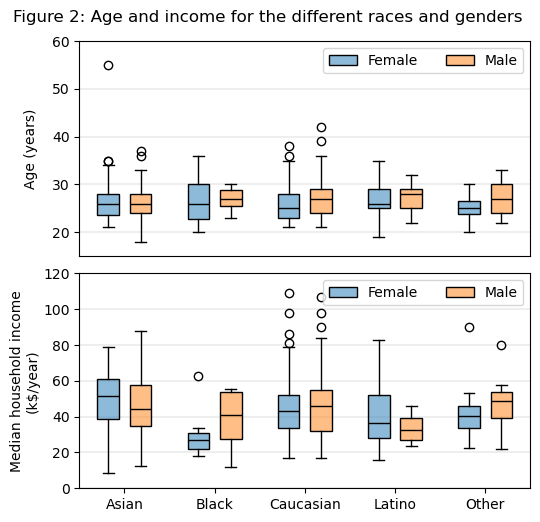

In [7]:
ages, incomes = {}, {}
for race, df_ in racial_df.groupby('race'):
    
    vals_f = df_.loc[df_['gender'] == 'Female', 'age']
    vals_m = df_.loc[df_['gender'] == 'Male', 'age']
    ages[race] = [vals_f[~np.isnan(vals_f)], vals_m[~np.isnan(vals_m)]]
    
    vals_f = df_.loc[df_['gender'] == 'Female', 'income']
    vals_m = df_.loc[df_['gender'] == 'Male', 'income']
    incomes[race] = [vals_f[~np.isnan(vals_f)], vals_m[~np.isnan(vals_m)]]


fig2, axs2 = plt.subplots(
    nrows=2, ncols=1, figsize=(5.5, 5.2), dpi=100,
    gridspec_kw={'left': 0.14, 'right': 0.96, 'top': 0.92, 'bottom': 0.06, 'hspace': 0.08})
fig2.suptitle("Figure 2: Age and income for the different races and genders",
              x=0.02, ha='left')


for i, (race, race_ages) in enumerate(ages.items()):
    bplot = axs2[0].boxplot(race_ages, positions=[i+0.82, i+1.18],
                            widths=0.24, patch_artist=True,
                            medianprops={'color': 'k'})
    for patch, color in zip(bplot['boxes'], ['#1F77B480', '#FF7F0E80']):
        patch.set_facecolor(color)
axs2[0].set_xlim(0.5, 5.5)
axs2[0].tick_params(bottom=False, labelbottom=False)
axs2[0].set_ylim(15, 60)
axs2[0].set_ylabel('Age (years)', labelpad=10)
axs2[0].grid(visible=True, axis='y', linewidth=0.3)
axs2[0].legend(handles=bplot['boxes'], labels=['Female', 'Male'], ncols=2)


for i, (race, race_incomes) in enumerate(incomes.items()):
    bplot = axs2[1].boxplot(race_incomes, positions=[i+0.82, i+1.18],
                            widths=0.24, patch_artist=True,
                            medianprops={'color': 'k'})
    for patch, color in zip(bplot['boxes'], ['#1F77B480', '#FF7F0E80']):
        patch.set_facecolor(color)

axs2[1].set_xlim(0.5, 5.5)
axs2[1].set_xticks(np.arange(1, 6), list(ages.keys()))
axs2[1].set_ylim(0, 120000)
axs2[1].set_yticks(np.linspace(0, 120000, 7), np.arange(0, 130, 20))
axs2[1].set_ylabel('Median household income\n(k$/year)', labelpad=2)
axs2[1].grid(visible=True, axis='y', linewidth=0.3)
axs2[1].legend(handles=bplot['boxes'], labels=['Female', 'Male'], ncols=2)

plt.show()

We show in figure 2 box plots of the age (top panel) and estimated income (bottom panel) distributions, for each gender/race pair. Both the ages and income are in the same range. Black females seem to have lower salary than the rest. This may well be fluctuations due to the low number of participants in this category.

### Interests

Participants were asked to rate their interests on a 1-10 scale for a set of 18 selected activities such as exercising, reading, watching movies.

In [8]:
interests = ['sports', 'tvsports', 'exercise', 'dining', 'museums', 'art',
             'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater',
             'movies', 'concerts', 'music', 'shopping', 'yoga']
interests_df = subject_df.loc[:, ['gender'] + interests]
mean_interests = interests_df.groupby('gender').mean()
interests_data = interests_df.iloc[:, 1:].to_numpy().T
interests_data = [col[~np.isnan(col)] for col in interests_data]

interests_df.describe()

,gender,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga
count,551.000000,544.000000,544.000000,544.000000,544.000000,544.000000,544.000000,544.000000,544.000000,544.000000,544.000000,544.000000,544.000000,544.000000,544.000000,544.000000,544.000000,544.000000
mean,0.502722,6.395221,4.549632,6.286765,7.775735,6.972426,6.689338,5.757353,3.840074,5.751838,7.647059,5.325368,6.761029,7.898897,6.843750,7.875000,5.604779,4.415441
std,0.500447,2.630753,2.801164,2.449965,1.778032,2.059245,2.273435,2.566239,2.610746,2.485871,2.002869,2.539344,2.273611,1.720550,2.154151,1.788803,2.615307,2.757915
min,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,0.000000,4.000000,2.000000,5.000000,7.000000,6.000000,5.000000,4.000000,1.000000,4.000000,7.000000,3.000000,5.000000,7.000000,5.750000,7.000000,4.000000,2.000000
50%,1.000000,7.000000,4.000000,7.000000,8.000000,7.000000,7.000000,6.000000,3.000000,6.000000,8.000000,6.000000,7.000000,8.000000,7.000000,8.000000,6.000000,4.000000
75%,1.000000,8.250000,7.000000,8.000000,9.000000,8.250000,8.000000,8.000000,6.000000,8.000000,9.000000,7.000000,9.000000,9.000000,8.000000,9.000000,8.000000,7.000000
max,1.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,14.000000,10.000000,13.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


We can see that some participants gave answers outside the prescribed range of 1 - 10. Misspecified answers are a common problem of such surveys. This is one of the difficulties for the analysis this dataset.

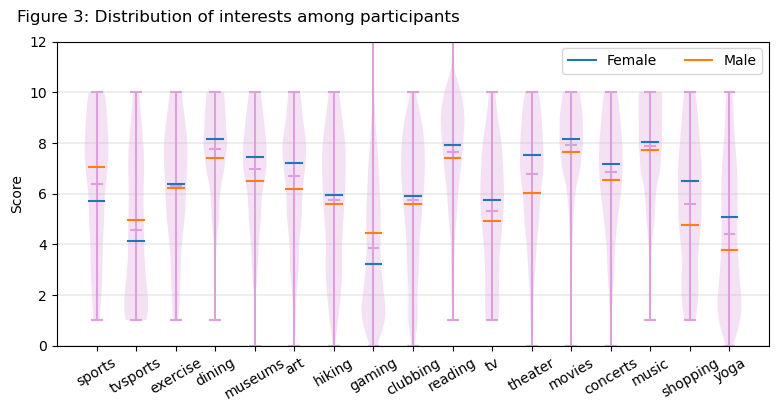

In [9]:
fig3, ax3 = plt.subplots(
    nrows=1, ncols=1, figsize=(8, 4), dpi=100,
    gridspec_kw={'left': 0.07, 'right': 0.96, 'top': 0.9, 'bottom': 0.14, 'hspace': 0.08})
fig3.suptitle("Figure 3: Distribution of interests among participants",
              x=0.02, ha='left')


vplot = ax3.violinplot(
    interests_data, positions=np.arange(1, 18), widths=0.6, showmeans=True)
for i, (m0, m1) in enumerate(mean_interests.T.to_numpy(), start=1):
    line_f, = ax3.plot([i-0.2, i+0.2], [m0, m0], color='tab:blue')
    line_m, = ax3.plot([i-0.2, i+0.2], [m1, m1], color='tab:orange')

ax3.set_xlim(0, 18)
ax3.set_xticks(np.arange(1, 18), interests, rotation=30)
ax3.set_ylim(0, 12)
ax3.set_ylabel('Score', labelpad=4)
ax3.grid(visible=True, axis='y', linewidth=0.3)
ax3.legend(handles=[line_f, line_m], labels=['Female', 'Male'], ncols=2)


for elt in vplot['bodies']:
    elt.set_facecolor('plum')
for elt in ['cbars', 'cmaxes', 'cmins', 'cmeans']:
    vplot[elt].set_edgecolor('plum')

plt.show()

We represent violin plots of the various interests in figure 3. The data aggregates both genders, and we simply show the mean for each gender as blue (females) and orange (males) horizontal lines. Females generally show more interest in everything, except for sports, tv-sports and gaming, which are traditionally attributed to men.

### Attributes

Analyzing the data relative to attributes is more difficult. The dataset contains many different attribute ratings:
- 'What are you looking for?'
- 'What you think the opposite sex looks for?'
- 'How do you think you measure up?'
- 'What you think your fellow men/women look for?'
- 'How do you think other perceive you?'
- 'Actual importance of attributes in your decisions'
Moreover, there are other problems:
- The ratings were not asked for consistently across different dating sessions (sometimes on a 1-10 scale, sometimes by distributing 100 points)
- There are a lot of missing data
- The data are sometimes misspecified (rating ouside 1-10 range or with a sum different than 100)

In the following single-subject analysis we will focus on how people perceive themselves (`<attribute>3_*`) and what they are looking for (`<attribute>1_*`).

In [10]:
attributes = ['Attractive', 'Sincere', 'Intelligent', 'Fun', 'Ambitious', 'Shared\ninterests']
attr_kw = ['attr', 'sinc', 'intel', 'fun', 'amb', 'shar']

In [11]:
cols = [[kw + f'{i}_{j}' for i in range(1, 6) for kw in attr_kw[:-1]]
        for j in range(1, 4)]
data = {'Before dating': subject_df.loc[:, cols[0]].count().to_numpy(),
        'After dating': subject_df.loc[:, cols[1]].count().to_numpy(),
        'Follow-up': subject_df.loc[:, cols[2]].count().to_numpy()}
df_ = pd.DataFrame.from_dict(data)
df_.index = [kw + f'{i}' for i in range(1, 6) for kw in attr_kw[:-1]]
df_

,Before dating,After dating,Follow-up
attr1,544,484,263
sinc1,544,485,263
intel1,544,485,263
fun1,543,485,263
amb1,542,485,263
attr2,544,368,193
sinc2,544,368,193
intel2,544,368,193
fun2,544,368,193
amb2,543,368,193


The decrease of number of attribute evaluation responses over time illustrates well the missing data problem.

#### Evolution of attribute rating

We will now look at how the participants change their attributes rating over time. For our two selected attribute ratings (self-evaluation and looked-for), the researchers ask for 4 ratings: before (`'*_1'`), during (`'*_s'`), after (`'*_2'`) the speed dating experiment, and also during the follow-up (`'*_3'`).

In [12]:
ev_cols = [kw + f'3_{j}' for j in [1, 's', 2, 3] for kw in attr_kw[:-1]]
self_ev_df = subject_df.loc[:, ev_cols] # self evaluation dataframe
self_ev_df.count()

attr3_1     542
sinc3_1     542
intel3_1    542
fun3_1      542
amb3_1      542
attr3_s     276
sinc3_s     276
intel3_s    276
fun3_s      276
amb3_s      276
attr3_2     485
sinc3_2     485
intel3_2    485
fun3_2      485
amb3_2      485
attr3_3     263
sinc3_3     263
intel3_3    263
fun3_3      263
amb3_3      263
dtype: int64

Data is mostly available before (`'*_1'`) and after (`'*_2'`) the speed dating experiment. We will therefore only consider the evolution between these two moments.

The self-declared looked-for attributes must be normalized:
- The rating scale is not homogeneous, we have both 1-10 pts scale ratings, and ratings with 100 pts distributed.
- Even when they should, the ratings sometimes do not sum to 100.

We choose to normalize them so that they sum to 100.

In [13]:
# 4 sets of self assessed attributes
self_ev = np.array(np.split(self_ev_df.to_numpy(), 4, axis=1))
ev_diff = self_ev[2] - self_ev[0]
ev_diff = ev_diff[~np.any(np.isnan(ev_diff), axis=1)]

# do the same with "what I look for"
lf_cols = [kw + f'1_{j}' for j in [1, 's', 2, 3] for kw in attr_kw]
self_lf_df = subject_df.loc[:, lf_cols] # self lookfor dataframe
self_lf_df.count()

self_lf = np.array(np.split(self_lf_df.to_numpy(), 4, axis=1))
self_lf = 100 * self_lf / np.sum(self_lf, axis=-1, keepdims=True) # re-scale to a sum of 100
lf_diff = self_lf[2] - self_lf[0]
lf_diff = lf_diff[~np.any(np.isnan(lf_diff), axis=1)]

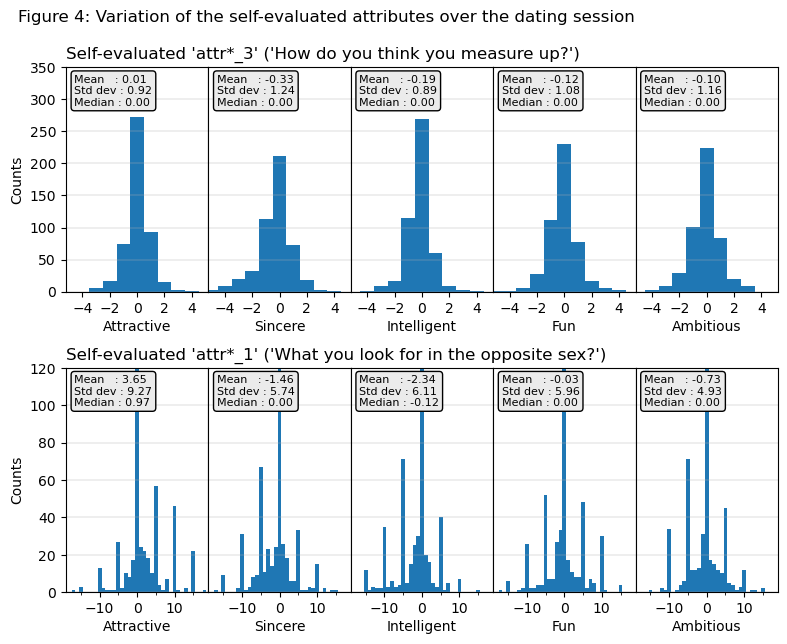

In [14]:
fig4, axs4 = plt.subplots(
    nrows=2, ncols=5, figsize=(8, 6.4), dpi=100,
    gridspec_kw={'left': 0.08, 'right': 0.97, 'top': 0.89, 'bottom': 0.07,
                 'wspace': 0, 'hspace': 0.34})
fig4.suptitle("Figure 4: Variation of the self-evaluated attributes over the dating session",
              x=0.02, ha='left', fontsize=12)

for i, ax in enumerate(axs4[0]):
    ax.hist(ev_diff[:, i], bins=np.linspace(-5.5, 5.5, 12))
    ax.text(0.06, 0.83, textstr(ev_diff[:, i]),
            transform=ax.transAxes, fontsize=8,
            bbox={'boxstyle': 'round', 'facecolor': '0.92'})
    ax.set_xlim(-5.2, 5.2)
    ax.set_ylim(0, 350)
    ax.grid(visible=True, axis='y', linewidth=0.3)
    ax.tick_params(left=False, labelleft=False)
    ax.set_xticks([-4, -2, 0, 2, 4])
    ax.set_xlabel(attributes[i], labelpad=3)
axs4[0, 0].tick_params(left=True, labelleft=True)
axs4[0, 0].set_ylabel('Counts')
axs4[0, 0].set_title("Self-evaluated 'attr*_3' ('How do you think you measure up?')",
                     x=0, ha='left')


for i, ax in enumerate(axs4[1]):
    ax.hist(lf_diff[:, i], bins=np.linspace(-19.5, 19.5, 40))
    ax.text(0.06, 0.83, textstr(lf_diff[:, i]),
            transform=ax.transAxes, fontsize=8,
            bbox={'boxstyle': 'round', 'facecolor': '0.92'})
    
    ax.set_xlim(-19, 19)
    ax.set_ylim(0, 120)
    ax.grid(visible=True, axis='y', linewidth=0.3)
    ax.tick_params(left=False, labelleft=False)
    ax.set_xticks([-10, 0, 10])
    ax.set_xticks([-15, -10, -5, 0, 5, 10, 15], minor=True)
    ax.set_xlabel(attributes[i], labelpad=3)
axs4[1, 0].tick_params(left=True, labelleft=True)
axs4[1, 0].set_ylabel('Counts')
axs4[1, 0].set_title("Self-evaluated 'attr*_1' ('What you look for in the opposite sex?')",
                     x=0, ha='left')

plt.show()

Figure 4 presents the variation of self-evaluation (top panel) and looked-for evaluation (bottom panel) over the course of the speed dating event.
The self evaluation is given with a 1-10 scale rating, while the looked-for evaluation is given by attributing 100 points.
There is no change over time on average (maybe a slight decrease ?), yet with some significant but low variations among individuals.

The participants probably re-evaluate their answers based on how went the experiments, yet stay rather consistent over time.

#### Difference between self-perceived attributes and peer evaluations

We focus here on the differences between one's perception of their own attributes and the perception of peers. After each date, participants were asked to rate the partners' attributes on a 1-10 scale. We use the averages of these ratings to aggregate partners perception.

In [15]:
# self-evauated attributes
sev_iids = self_ev_df.index.to_numpy()[~np.all(np.isnan(self_ev), axis=(0, 2))]
sev_genders = subject_df.loc[sev_iids]['gender'].to_numpy()
sev_attrs = self_ev[:, ~np.all(np.isnan(self_ev), axis=(0, 2))]
sev_attrs = np.mean(sev_attrs, axis=0, where=~np.isnan(sev_attrs))

# partner-evaluated attributes
pev_iids, pev_attrs = [], []
partner_ev_df = df.loc[:, ['pid'] + attr_kw[:-1]] # self evaluates partned
for iid, df_ in partner_ev_df.groupby('pid'):
    attr_eval = df_.loc[:, attr_kw[:-1]].to_numpy()
    mask = ~np.isnan(attr_eval)
    if np.all(np.any(mask, axis=0)):
        pev_iids.append(iid)
        pev_attrs.append(np.mean(attr_eval, axis=0, where=mask))
pev_iids, pev_attrs = np.array(pev_iids), np.array(pev_attrs)
pev_genders = subject_df.loc[pev_iids]['gender'].to_numpy()

# evaluation differences
sev_idx = np.isin(sev_iids, pev_iids, assume_unique=True)
pev_idx = np.isin(pev_iids, sev_iids, assume_unique=True)
ev_diff = sev_attrs[sev_idx] - pev_attrs[pev_idx]
ev_genders = sev_genders[sev_idx]

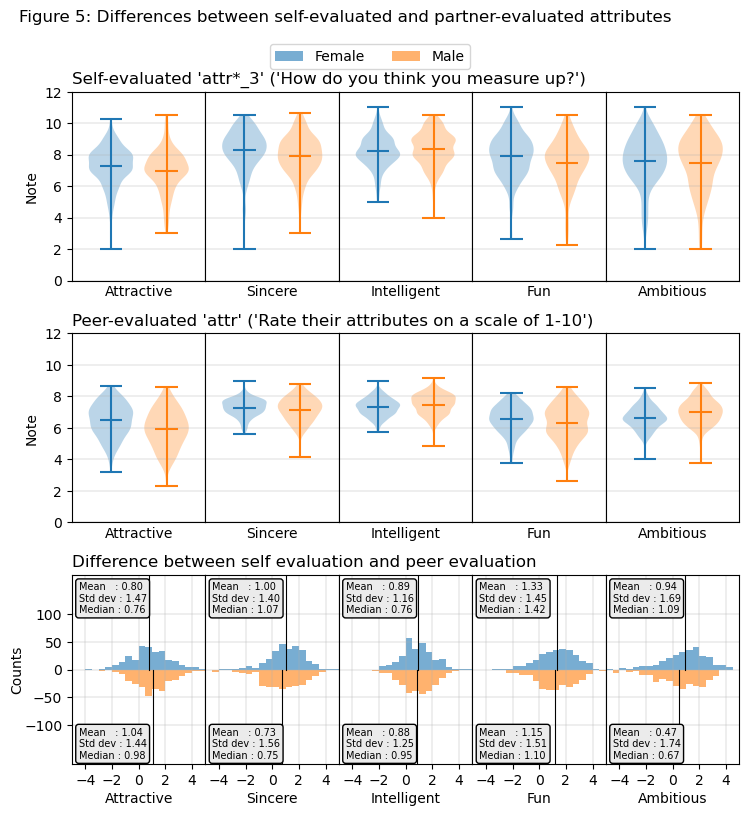

In [16]:
fig5, axs5 = plt.subplots(
    nrows=3, ncols=5, figsize=(7.5, 8.2), dpi=100,
    gridspec_kw={'left': 0.09, 'right': 0.98, 'top': 0.88, 'bottom': 0.06,
                 'wspace': 0, 'hspace': 0.28})
fig5.suptitle("Figure 5: Differences between self-evaluated and partner-evaluated attributes",
              x=0.02, ha='left')

for i, ax in enumerate(axs5[0]):
    sev_f = sev_attrs[sev_genders==0, i]
    sev_m = sev_attrs[sev_genders==1, i]
    ax.violinplot(sev_f, positions=[-0.5], widths=0.8, showmeans=True)
    ax.violinplot(sev_m, positions=[0.5], widths=0.8, showmeans=True)
    
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(0, 12)
    ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    ax.grid(visible=True, axis='y', linewidth=0.3)
    ax.set_xlabel(attributes[i], labelpad=3)
    
axs5[0, 0].tick_params(bottom=False, left=True, labelleft=True)
axs5[0, 0].set_ylabel('Note')
axs5[0, 0].set_title("Self-evaluated 'attr*_3' ('How do you think you measure up?')",
                     x=0, ha='left')


for i, ax in enumerate(axs5[1]):
    pev_f = pev_attrs[pev_genders==0, i]
    pev_m = pev_attrs[pev_genders==1, i]
    ax.violinplot(pev_f, positions=[-0.5], widths=0.8, showmeans=True)
    ax.violinplot(pev_m, positions=[0.5], widths=0.8, showmeans=True)
    
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(0, 12)
    ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    ax.grid(visible=True, axis='y', linewidth=0.3)
    ax.set_xlabel(attributes[i], labelpad=3)
    
axs5[1, 0].tick_params(left=True, labelleft=True)
axs5[1, 0].set_ylabel('Note')
axs5[1, 0].set_title("Peer-evaluated 'attr' ('Rate their attributes on a scale of 1-10')",
                     x=0, ha='left')


for i, ax in enumerate(axs5[2]):
    evd_f = ev_diff[ev_genders==0, i]
    evd_m = ev_diff[ev_genders==1, i]
    _, _, patch_f = ax.hist(evd_f, bins=np.linspace(-14.5, 14.5, 59),
                            alpha=0.6)
    _, _, patch_m = ax.hist(evd_m, bins=np.linspace(-14.5, 14.5, 59),
                            weights=np.full_like(evd_m, -1), alpha=0.6)
    ax.plot([np.mean(evd_f)]*2, [0, 170], color='k', linewidth=0.8)
    ax.plot([np.mean(evd_m)]*2, [0, -170], color='k', linewidth=0.8)
    ax.text(0.05, 0.8, textstr(evd_f), transform=ax.transAxes,
            fontsize=7, bbox={'boxstyle': 'round', 'facecolor': '0.92'})
    ax.text(0.05, 0.03, textstr(evd_m), transform=ax.transAxes,
            fontsize=7, bbox={'boxstyle': 'round', 'facecolor': '0.92'})
    
    ax.set_xlim(-5, 5)
    ax.set_ylim(-170, 170)
    ax.grid(visible=True, axis='both', linewidth=0.3)
    ax.tick_params(left=False, labelleft=False)
    ax.set_xticks([-4, -2, 0, 2, 4])
    ax.set_yticks([-100, -50, 0, 50, 100])
    ax.set_xlabel(attributes[i], labelpad=3)
    
axs5[2, 0].tick_params(left=True, labelleft=True)
axs5[2, 0].set_ylabel('Counts', labelpad=0)
axs5[2, 0].set_title("Difference between self evaluation and peer evaluation",
                     x=0, ha='left')

fig5.legend(handles=[patch_f, patch_m], labels=['Female', 'Male'],
            ncols=2, loc=(0.36, 0.915), alignment='center')

plt.show()

Figure 5 presents for each attribute the participants self-perception of their own attributes (top panel), partners evaluation (middle panel), and the evaluation difference (bottom panel). We note that the amplitude of self evaluations is much larger than that of peer evaluation. This is mostly an effect of the averaging, which includes more data from peer evaluation. The ratings are quite similar for both men and women, in both self and peer-evaluations. The mean rating is around 8 for each attribute in self-evaluations, and around 7 for peer evaluations. This systematic overestimation of one's attributes is highlighted in the bottom panel, where we observe a consistent one point difference across all attributes for both genders.

We can confirm that these differences are significant by doing a simple one-sample t-test.

In [17]:
ttest_res_f = ttest_1samp(ev_diff[ev_genders==0], popmean=0, alternative='two-sided')
ttest_ci_f = ttest_res_f.confidence_interval(confidence_level=0.99)
print('===== Female t-test results ======')
pd.DataFrame({'p-value': ttest_res_f.pvalue,
              '99% CI (low)': ttest_ci_f.low,
              '99% CI (high)': ttest_ci_f.high},
             index=attributes[:-1])

===== Female t-test results ======


,p-value,99% CI (low),99% CI (high)
Attractive,6.168773e-17,0.568562,1.033351
Sincere,4.532964e-26,0.779031,1.220025
Intelligent,5.523274e-29,0.704652,1.069796
Fun,8.949085e-38,1.101867,1.559241
Ambitious,1.212185e-17,0.673625,1.204937


In [18]:
ttest_res_m = ttest_1samp(ev_diff[ev_genders==1], popmean=0, alternative='two-sided')
ttest_ci_m = ttest_res_m.confidence_interval(confidence_level=0.99)
print('===== Male t-test results ======')
pd.DataFrame({'p-value': ttest_res_m.pvalue,
              '99% CI (low)': ttest_ci_m.low,
              '99% CI (high)': ttest_ci_m.high},
             index=attributes[:-1])

===== Male t-test results ======


,p-value,99% CI (low),99% CI (high)
Attractive,5.301777e-27,0.813436,1.261724
Sincere,1.429469e-13,0.488477,0.976805
Intelligent,7.424414e-26,0.682515,1.072481
Fun,2.450735e-29,0.915589,1.386558
Ambitious,9.371983e-06,0.200904,0.743254


The results clearly confirm our observations with p-values below $10^{-6}$ for all differences. Men and women overestimate their fun the most. Women overestimate more their sincerity and ambition than men, and men overestimate mote their attractiveness.

### Correlation between self-evaluated and empirical looked-for attributes in partners

We now investigate the correlation between the attributes that the participants declare looking for (`<attribute>1_*`) and the attribute ratings of the partners which they are willing to date again (`<attribute>`).

The self-declared looked-for attributes are normalized for the same reasons as when we studied the evolution of the ratings (figure 4).

In [19]:
gdf = df.groupby('gender')

# females
lf_df_f = gdf.get_group(0).loc[:, [kw + '1_1' for kw in attr_kw] + attr_kw]
lf_df_f.iloc[:, :6] = lf_df_f.iloc[:, :6].div(lf_df_f.iloc[:, :6].sum(axis=1), axis=0)
lf_corr_f = lf_df_f.corr().iloc[:6, 6:].to_numpy()

# males
lf_df_m = gdf.get_group(1).loc[:, [kw + '1_1' for kw in attr_kw] + attr_kw]
lf_df_m.iloc[:, :6] = lf_df_m.iloc[:, :6].div(lf_df_m.iloc[:, :6].sum(axis=1), axis=0)
lf_corr_m = lf_df_m.corr().iloc[:6, 6:].to_numpy()

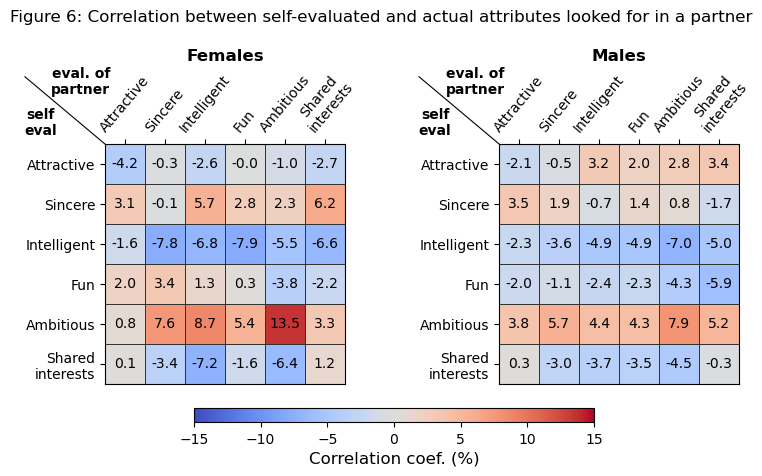

In [20]:
fig6, axs6 = plt.subplots(
    nrows=1, ncols=2, figsize=(8, 4.8), dpi=100,
    gridspec_kw={'left': 0.09, 'right': 0.98, 'top': 0.7, 'bottom': 0.2, 'wspace': 0.24})
cax6 = fig6.add_axes((0.25, 0.12, 0.5, 0.03))
fig6.suptitle("Figure 6: Correlation between self-evaluated and actual attributes looked for in a partner",
              x=0.02, ha='left')


axs6[0].set_aspect('equal')
heatmap = axs6[0].pcolormesh(lf_corr_f[::-1]*100, cmap='coolwarm', vmin=-15, vmax=15,
                             edgecolors='0.2', linewidth=0.5)
axs6[0].tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
axs6[0].set_xticks(np.linspace(0.5, 5.5, 6), attributes, rotation=50)
axs6[0].set_yticks(np.linspace(0.5, 5.5, 6), attributes[::-1])
for (i, j), c in np.ndenumerate(lf_corr_f[::-1]*100):
    axs6[0].text(j+0.5, i+0.5, f'{c:.1f}', ha='center', va='center')

axs6[0].set_title('Females', fontweight='bold')
pos = axs6[0].get_position().bounds
x, y = pos[0], pos[1] + pos[3]
fig6.add_artist(Line2D([x-0.1, x], [y+0.14, y], color='k', lw=0.8))
fig6.text(x-0.03, y+0.13, 'eval. of\npartner', ha='center', va='center', fontweight='bold')
fig6.text(x-0.08, y+0.045, 'self\neval', ha='center', va='center', fontweight='bold')


axs6[1].set_aspect('equal')
heatmap = axs6[1].pcolormesh(lf_corr_m[::-1]*100, cmap='coolwarm', vmin=-15, vmax=15,
                             edgecolors='0.2', linewidth=0.5)
axs6[1].tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
axs6[1].set_xticks(np.linspace(0.5, 5.5, 6), attributes, rotation=50)
axs6[1].set_yticks(np.linspace(0.5, 5.5, 6), attributes[::-1])
for (i, j), c in np.ndenumerate(lf_corr_m[::-1]*100):
    axs6[1].text(j+0.5, i+0.5, f'{c:.1f}', ha='center', va='center')

axs6[1].set_title('Males', fontweight='bold')
pos = axs6[1].get_position().bounds
x, y = pos[0], pos[1] + pos[3]
fig6.add_artist(Line2D([x-0.1, x], [y+0.14, y], color='k', lw=0.8))
fig6.text(x-0.03, y+0.13, 'eval. of\npartner', ha='center', va='center', fontweight='bold')
fig6.text(x-0.08, y+0.045, 'self\neval', ha='center', va='center', fontweight='bold')


fig6.colorbar(heatmap, cax=cax6, orientation="horizontal", ticklocation="bottom")
cax6.set_title('Correlation coef. (%)', y=-3.4)


plt.show()

Figure 6 shows heatmaps of the Pearson's correlation coefficient for each attribute pair (self evaluation, evaluation of partner) for both men and women. The correlation is weak, below 10% for almost all pairs. We nevertheless observe the following.
- When looking for an ambitious partner, participants actually look for a parner that rates better on all attributes. This is especially true for women.
- When looking for an intelligent partner, participants actually look for a partner that rates worse on all attributes. This is, again, especially true for women.

The interpretation of these observations is unclear.

## <a id="dating"></a> Dating results analysis

Let us now explore the dating results proper. We will investigate the following:
- The effect of sharing a racial background on the atch probability
- The effect of interests affinity on the match probability
- The difference between expected and real number of matches over the dating session
- The difference between self-evaluated attributes and the evaluation of the partner's attributes when willing to date again.
- Age and income difference in matches
- A primality effect when deciding to date again someone

Some speed dating sessions have been designed with the additional constraint of a limited number of positive decisions about dating someone again.
This introduces constraints in some quantities, for instance in the maximal number of possible matches in a session. In the following analysis we do not
take this into account nor filter the data.

### Effect of race on the match probability

We begin by studying the match probability between participants for the different races represented.

In [21]:
race_match_df = df.loc[df['gender']==0, ['match', 'race', 'race_o']]
norm = race_match_df.groupby(['race', 'race_o']).count()
matches = race_match_df.loc[df['match']==1].groupby(['race', 'race_o']).count()

# convert to a 2D matrix
match_idx = {k: i for i, k in enumerate(list(races.keys()))}
race_matches = np.full((len(races), len(races)), np.nan, dtype=float)
for (i, j), v in (matches/norm).iterrows():
    race_matches[match_idx[i], match_idx[j]] = v['match']

print(f"Global match probability: {df['match'].mean():.4f}")

Global match probability: 0.1647


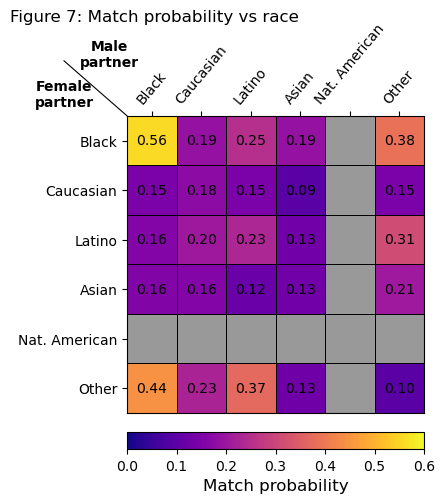

In [22]:
fig7, ax7 = plt.subplots(
    nrows=1, ncols=1, figsize=(4.5, 5), dpi=100,
    gridspec_kw={'left': 0.28, 'right': 0.94, 'top': 0.77, 'bottom': 0.17})
cax7 = fig7.add_axes((0.28, 0.1, 0.66, 0.035))
fig7.suptitle('Figure 7: Match probability vs race', x=0.02, ha='left')

ax7.set_aspect('equal')
cmap = plt.get_cmap('plasma').copy()
cmap.set_bad('0.6', 1)
heatmap = ax7.pcolormesh(race_matches[::-1], cmap=cmap, vmin=0, vmax=0.6,
                         edgecolors='k', linewidth=0.4)
ax7.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax7.set_xticks(np.linspace(0.5, 5.5, 6), list(races.values()), rotation=50)
ax7.set_yticks(np.linspace(0.5, 5.5, 6), list(races.values())[::-1])
for (i, j), p in np.ndenumerate(race_matches[::-1]):
    if not np.isnan(p):
        ax7.text(j+0.5, i+0.5, f'{p:.2f}', ha='center', va='center')

fig7.colorbar(heatmap, cax=cax7, orientation="horizontal", ticklocation="bottom")
cax7.set_title('Match probability', y=-2.8)

pos = ax7.get_position().bounds
x, y = pos[0], pos[1] + pos[3]
fig7.add_artist(Line2D([x-0.14, x], [y+0.11, y], color='k', lw=0.8))
fig7.text(0.24, 0.89, 'Male\npartner', ha='center', va='center', fontweight='bold')
fig7.text(0.14, 0.81, 'Female\npartner', ha='center', va='center', fontweight='bold')


plt.show()

We present in figure 7 the match probabilities between a female partner of given race (row) with a man of a second race (column). Although the matrix is *a priori* not symmetric, there is nevertheless a large level of symmetry between males and females. We note the following:
- Black people are quite likely to match. This is in contrast with other races, which are no particular affinity in terms of matches.
- Black people match frequently with 'other' races, which in turn match more with latinos
- Asian males are the less likely to match, significantly less than their women counterparts (this observation is actually well documented)

### Effect of interests affinity on match probability

In [23]:
int_corr = df['int_corr'].to_numpy()
match_int_corr = df.loc[df['match'] == 1, 'int_corr'].to_numpy()
bins = np.linspace(-1, 1, 41)

# make histogram
hist_ic = np.histogram(int_corr, bins=bins)[0]
hist_match_ic = np.histogram(match_int_corr, bins=bins)[0]

# match probability vs interests correlations
ic_vals = np.linspace(-0.975, 0.975, 40)
p_match = hist_match_ic / hist_ic # np.where(hist_ic, hist_ic, 1)
std_p_match = p_match * (1-p_match) / np.sqrt(np.where(hist_ic, hist_ic, 1))

attr_match_corr = df.loc[:, ['int_corr', 'match']].corr().iloc[0, 1]
print(f"Correlation between interests affinity and match probability: {attr_match_corr:.2f}")

Correlation between interests affinity and match probability: 0.03


/tmp/ipykernel_273485/2467574785.py:9: RuntimeWarning: invalid value encountered in divide
  p_match = hist_match_ic / hist_ic # np.where(hist_ic, hist_ic, 1)


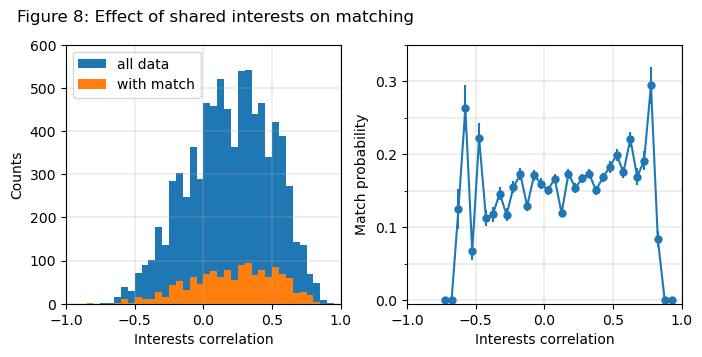

In [24]:
fig8, axs8 = plt.subplots(
    nrows=1, ncols=2, figsize=(7, 3.5), dpi=100,
    gridspec_kw={'left': 0.09, 'right': 0.97, 'top': 0.88, 'bottom': 0.14, 'wspace':0.24})
fig8.suptitle('Figure 8: Effect of shared interests on matching', x=0.02, ha='left')


axs8[0].bar(ic_vals, hist_ic, width=0.05, label='all data')
axs8[0].bar(ic_vals, hist_match_ic, width=0.05, label='with match')
axs8[0].set_xlim(-1, 1)
axs8[0].set_ylim(0, 600)
axs8[0].grid(visible=True, linewidth=0.3)
axs8[0].set_xlabel('Interests correlation')
axs8[0].set_ylabel('Counts')
axs8[0].legend()

axs8[1].errorbar(ic_vals, p_match, yerr=std_p_match,
             fmt='o-', markersize=5)

axs8[1].set_xlim(-1, 1)
axs8[1].set_ylim(-0.005, 0.35)
axs8[1].set_yticks([0, 0.1, 0.2, 0.3])
axs8[1].set_yticks([0.05, 0.15, 0.25, 0.35], minor=True)
axs8[1].grid(visible=True, which='both', linewidth=0.3)
axs8[1].set_xlabel('Interests correlation')
axs8[1].set_ylabel('Match probability')

plt.show()

We show in figure 8 the histograms of interests correlations (left panel) and the corresponding match probability (right panel). There is a clear tendency for the match probability to increase linearly with interests affinity. However, an increase of 1 point in interests correlation, leads to only 3.1% increased chances of match. This is a very weak effect since the interests correlation lies in the range [-1, 1].

### Expected versus real numbers of matches

In [25]:
iids = subject_df.index.to_numpy()
female_idx = np.array([i for i, iid in enumerate(iids)
                       if subject_df.loc[iid, 'gender'] == 0])
male_idx = np.array([i for i, iid in enumerate(iids)
                     if subject_df.loc[iid, 'gender'] == 1])

gdf = df.loc[:, ['iid', 'match', 'dec']].groupby('iid')
nmatch = np.array([gdf.get_group(i)['match'].sum() for i in iids])
exp_nmatch = subject_df.loc[iids, 'match_es'].to_numpy()

f_dmatch = (exp_nmatch - nmatch)[female_idx] # female match difference
m_dmatch = (exp_nmatch - nmatch)[male_idx]

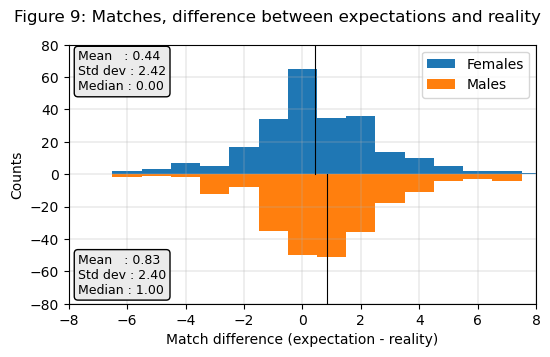

In [26]:
fig9, ax9 = plt.subplots(
    nrows=1, ncols=1, figsize=(5.5, 3.5), dpi=100,
    gridspec_kw={'left': 0.12, 'right': 0.97, 'top': 0.88, 'bottom': 0.14})
fig9.suptitle('Figure 9: Matches, difference between expectations and reality',
              x=0.02, ha='left')

bins = np.linspace(-9.5, 9.5, 20)
ax9.hist(f_dmatch, bins=bins, label='Females')
ax9.plot([np.mean(f_dmatch, where=~np.isnan(f_dmatch))]*2, [0, 80],
             color='k', linewidth=0.8)
ax9.hist(m_dmatch, bins=bins, weights=np.full_like(m_dmatch, -1), label='Males')
ax9.plot([np.mean(m_dmatch, where=~np.isnan(m_dmatch))]*2, [0, -80],
             color='k', linewidth=0.8)
ax9.text(0.02, 0.825, textstr(f_dmatch), transform=ax9.transAxes,
        fontsize=9, bbox={'boxstyle': 'round', 'facecolor': '0.92'})
ax9.text(0.02, 0.04, textstr(m_dmatch), transform=ax9.transAxes,
        fontsize=9, bbox={'boxstyle': 'round', 'facecolor': '0.92'})

ax9.set_xlim(-8, 8)
ax9.set_ylim(-80, 80)
ax9.grid(visible=True, linewidth=0.3)
ax9.set_xlabel('Match difference (expectation - reality)')
ax9.set_ylabel('Counts')
ax9.legend()


plt.show()

Figure 9 presents histograms of the difference between the expected and real number of matches during the dating session, distinguishing males and females. There is an overestimation of the number of matches one will get during the session, with a stronger effect for men than women. This can be due to two effects:
- People over-estimate themselves, thus the number of positive decisions they will *get*.
- People over-estimate partners, thus the number of positive decisions they will *give*.

As done before, we can check that this difference is significative with a one-sample t-test.

In [27]:
ttest_res_f = ttest_1samp(f_dmatch, popmean=0, nan_policy='omit', alternative='two-sided')
ttest_ci_f = ttest_res_f.confidence_interval(confidence_level=0.99)
ttest_res_m = ttest_1samp(m_dmatch, popmean=0, nan_policy='omit', alternative='two-sided')
ttest_ci_m = ttest_res_m.confidence_interval(confidence_level=0.99)

pd.DataFrame({'p-value': [ttest_res_f.pvalue, ttest_res_m.pvalue],
              '99% CI (low)': [ttest_ci_f.low, ttest_ci_m.low],
              '99% CI (high)': [ttest_ci_f.high, ttest_ci_m.high]},
             index=['Females', 'Males'])

,p-value,99% CI (low),99% CI (high)
Females,4.909101e-03,0.037951,0.849549
Males,2.273533e-07,0.425740,1.234511


The expectation vs reality difference is undubitably significant for men. and also for women, although the p-value in this latter case is closer to our threshold of 0.01.

### Correlation between dating decision ('dec'), partner appreciation ('like') and attributes

In [28]:
gdf = df.groupby('gender')
dec_attr_df_f = gdf.get_group(0).loc[:, ['dec', 'like'] + attr_kw]
dec_attr_df_m = gdf.get_group(1).loc[:, ['dec', 'like'] + attr_kw]
pd.concat([dec_attr_df_f.corr().iloc[2:, :2],
           dec_attr_df_m.corr().iloc[2:, :2]],
          axis=1, keys=['Female', 'Male'])

Female                Male          
            dec      like       dec      like
attr   0.444979  0.662400  0.515497  0.667812
sinc   0.222265  0.538253  0.190859  0.492010
intel  0.232939  0.534099  0.216818  0.493289
fun    0.416553  0.707323  0.407360  0.669037
amb    0.175386  0.449114  0.219542  0.457116
shar   0.413190  0.681339  0.387368  0.637508

Attractivity is the most desirable attribute for both men and wowen, especially for men. Being fun and sharing interests is also important for both genders. It is interesting to note that these two attributes are more correlated to the appreciation of the partner than attractivity, despite the latter being more relevant to the dating decision. Sincerity, intelligence and ambition are the least desirables attributes, but more so for the dating decision than for the partner appreciation.

### Age and income difference between matching partners

In [29]:
gd_df = df.loc[df['match']==1, ['pid', 'gender', 'age', 'income']]
gd_df['age_o'] = [subject_df.loc[int(pid), 'age'] for pid in gd_df['pid']]
gd_df['income_o'] = [subject_df.loc[int(pid), 'income'] for pid in gd_df['pid']]

gd_df = gd_df.loc[gd_df['gender']==0]
age_diff = (gd_df['age'] - gd_df['age_o']).to_numpy() # female - male
income_diff = (gd_df['income'] - gd_df['income_o']).to_numpy() 

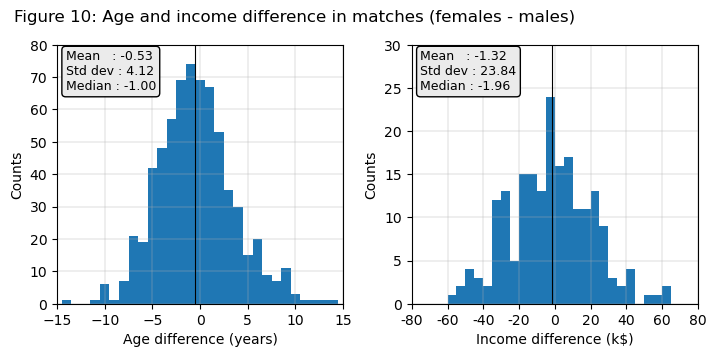

In [30]:
fig10, axs10 = plt.subplots(
    nrows=1, ncols=2, figsize=(7.2, 3.5), dpi=100,
    gridspec_kw={'left': 0.08, 'right': 0.97, 'top': 0.88, 'bottom': 0.14, 'wspace':0.24})
fig10.suptitle('Figure 10: Age and income difference in matches (females - males)',
               x=0.02, ha='left')


axs10[0].hist(age_diff, bins=np.linspace(-14.5, 14.5, 30))
axs10[0].plot([np.mean(age_diff, where=~np.isnan(age_diff))]*2, [0, 80],
              color='k', linewidth=0.8)
axs10[0].text(0.03, 0.825, textstr(age_diff), transform=axs10[0].transAxes,
              fontsize=9, bbox={'boxstyle': 'round', 'facecolor': '0.92'})

axs10[0].set_xlim(-15, 15)
axs10[0].set_ylim(0, 80)
axs10[0].grid(visible=True, linewidth=0.3)
axs10[0].set_xlabel('Age difference (years)')
axs10[0].set_ylabel('Counts')
# axs10[0].legend()


axs10[1].hist(income_diff, bins=np.linspace(-65e3, 65e3, 27))
axs10[1].plot([np.mean(income_diff, where=~np.isnan(income_diff))]*2, [0, 30],
              color='k', linewidth=0.8)
axs10[1].text(0.03, 0.825, textstr(income_diff/1e3), transform=axs10[1].transAxes,
              fontsize=9, bbox={'boxstyle': 'round', 'facecolor': '0.92'})

axs10[1].set_xlim(-80e3, 80e3)
axs10[1].set_ylim(0, 30)
axs10[1].set_xticks(np.linspace(-80e3, 80e3, 9), np.arange(-80, 100, 20))
axs10[1].grid(visible=True, which='both', linewidth=0.3)
axs10[1].set_xlabel('Income difference (k$)')
axs10[1].set_ylabel('Counts')

plt.show()

Figure 10 presents the age (left panel) and income (right panel) difference between the female and male partner. There is a tendency for the age difference to be negative (males are older than women), but the distribution is broad and the effect appears limited (less than 1 year). The average income difference is negligible.

The measured effects are smaller than in the general population, which is probably related to the fact that this is a student population, hence rather homogeneous in terms of age and income.

In [31]:
ttest_res_age = ttest_1samp(age_diff, popmean=0, nan_policy='omit', alternative='two-sided')
ttest_ci_age = ttest_res_age.confidence_interval(confidence_level=0.99)
ttest_res_income = ttest_1samp(income_diff, popmean=0, nan_policy='omit', alternative='two-sided')
ttest_ci_income = ttest_res_income.confidence_interval(confidence_level=0.99)

pd.DataFrame({'p-value': [ttest_res_age.pvalue, ttest_res_income.pvalue],
              '99% CI (low)': [ttest_ci_age.low, ttest_ci_income.low],
              '99% CI (high)': [ttest_ci_age.high, ttest_ci_income.high]},
             index=['Age difference', 'Income difference'])

,p-value,99% CI (low),99% CI (high)
Age difference,0.000909,-0.940449,-0.119075
Income difference,0.434477,-5705.241442,3064.425521


As expected, with a one-sample t-test for these two quantities, we conclude only to a significative age difference.nicee

### Attributes difference associated to positive dating decisions

In [32]:
attr_data = df.loc[df['dec']==1, ['gender'] + [kw + '3_1' for kw in attr_kw[:-1]] + attr_kw[:-1]]
attr_data = attr_data.astype(float).to_numpy()

bins = np.linspace(-10.5, 10.5, 22)
x = np.linspace(-10, 10, 21)

# females
f_attr = attr_data[attr_data[:, 0]==0, 1:]
f_attr_diff = f_attr[:, 5:] - f_attr[:, :5] # self eval - other eval
f_attr_hist = [np.histogram(d, bins=bins)[0] for d in f_attr_diff.T]
f_attr_mean = np.mean(f_attr_diff, axis=0, where=~np.isnan(f_attr_diff))

# males
m_attr = attr_data[attr_data[:, 0]==1, 1:]
m_attr_diff = m_attr[:, 5:] - m_attr[:, :5]
m_attr_hist = [np.histogram(d, bins=bins)[0] for d in m_attr_diff.T]
m_attr_mean = np.mean(m_attr_diff, axis=0, where=~np.isnan(m_attr_diff))

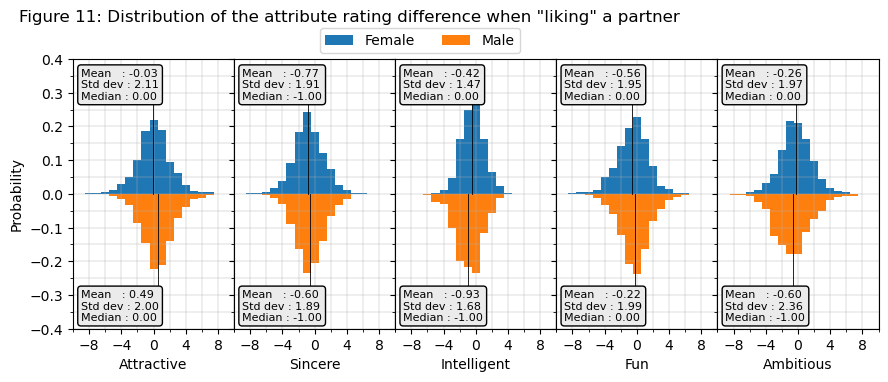

In [33]:
fig11, axs11 = plt.subplots(
    nrows=1, ncols=5, figsize=(9, 3.8), dpi=100, sharex=True, sharey=True,
    gridspec_kw={'left': 0.08, 'right': 0.975, 'top': 0.85, 'bottom': 0.14, 'wspace': 0})
fig11.suptitle('Figure 11: Distribution of the attribute rating difference when "liking" a partner',
               x=0.02, ha='left')

for i, ax in enumerate(axs11):
    bar_f = ax.bar(x, f_attr_hist[i]/np.sum(f_attr_hist[i]), width=1)
    ax.plot([f_attr_mean[i]]*2, [0, 0.3], color='k', linewidth=0.6)
    ax.text(0.05, 0.85, textstr(f_attr_diff[:, i]), transform=ax.transAxes,
            fontsize=8, bbox={'boxstyle': 'round', 'facecolor': '0.92'})
    bar_m = ax.bar(x, -m_attr_hist[i]/np.sum(m_attr_hist[i]), width=1)
    ax.plot([m_attr_mean[i]]*2, [0, -0.3], color='k', linewidth=0.6)
    ax.text(0.05, 0.03, textstr(m_attr_diff[:, i]), transform=ax.transAxes,
            fontsize=8, bbox={'boxstyle': 'round', 'facecolor': '0.92'})
    
    ax.set_xlim(-10, 10)
    ax.set_xticks(np.arange(-8, 10, 4))
    ax.set_xticks(np.arange(-10, 12, 4), minor=True)
    ax.set_ylim(-0.4, 0.4)
    ax.set_yticks(np.linspace(-0.35, 0.35, 8), minor=True)
    ax.grid(visible=True, which='both', linewidth=0.3)
    ax.set_xlabel(attributes[i])

axs11[0].set_ylabel('Probability')
fig11.legend(handles=[bar_f, bar_m], labels=['Female', 'Male'],
             ncols=2, loc=(0.36, 0.86), alignment='center')

plt.show()

We present in figure 11 hitograms of the difference between self-evaluated attribute ratings (`<attribute>3_*`) and the evaluation of partner attributes (`<attribute>`) when one is willing to date the partner again. The results here are harder to interpret due to the bias introduced by the attributes rating distributions, and possibly the fact that people are more severe towards other than themselves. However, we note that the histograms are skewed toward negative values when considering the ambition and intelligence difference in men. In other words, it seems to be a turndown when a woman appears more intelligent or ambitious to the man than himself.

In [34]:
print('===== Female t-test results ======')
ttest_res_f = ttest_1samp(f_attr_diff, popmean=0, nan_policy='omit', alternative='two-sided')
ttest_ci_f = ttest_res_f.confidence_interval(confidence_level=0.99)
pd.DataFrame({'p-value': ttest_res_f.pvalue,
              '99% CI (low)': ttest_ci_f.low,
              '99% CI (high)': ttest_ci_f.high},
             index=attributes[:-1])

===== Female t-test results ======


,p-value,99% CI (low),99% CI (high)
Attractive,5.906005e-01,-0.169593,0.111044
Sincere,1.328798e-51,-0.901485,-0.647246
Intelligent,6.708634e-27,-0.514030,-0.318072
Fun,3.462645e-27,-0.687185,-0.426467
Ambitious,1.222291e-06,-0.393554,-0.121141


In [35]:
print('===== Male t-test results ======')
ttest_res_m = ttest_1samp(m_attr_diff, popmean=0, nan_policy='omit', alternative='two-sided')
ttest_ci_m = ttest_res_m.confidence_interval(confidence_level=0.99)
pd.DataFrame({'p-value': ttest_res_m.pvalue,
              '99% CI (low)': ttest_ci_m.low,
              '99% CI (high)': ttest_ci_m.high},
             index=attributes[:-1])

===== Male t-test results ======


,p-value,99% CI (low),99% CI (high)
Attractive,4.083881e-27,0.378301,0.611377
Sincere,5.743603e-42,-0.707885,-0.486430
Intelligent,8.278520e-114,-1.024050,-0.827343
Fun,2.138059e-06,-0.333831,-0.099067
Ambitious,1.144171e-26,-0.741786,-0.457121


The t-tests carried here reveal a neat turndown effect of a greater perceived intelligence of the woman partner for men.

### Primality effect in dating decision

We conclude by investigating a form of primality effect in dating.

In [36]:
order_counts = df['order'].value_counts().to_numpy()
likes_vs_order = df['order'].loc[df['dec'] == 1].value_counts()

like_prob_df = df.loc[:, ['order', 'dec']].groupby('order').mean()
order = like_prob_df.index.to_numpy()
like_prob = like_prob_df['dec'].to_numpy() / 2
like_std = like_prob * (1 - like_prob) / np.sqrt(order_counts)

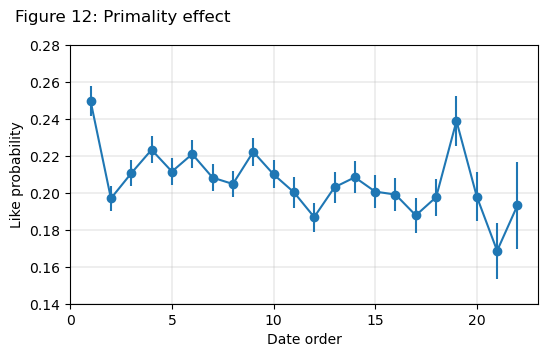

In [37]:
fig12, ax12 = plt.subplots(
    nrows=1, ncols=1, figsize=(5.5, 3.5), dpi=100,
    gridspec_kw={'left': 0.12, 'right': 0.97, 'top': 0.88, 'bottom': 0.14})
fig12.suptitle('Figure 12: Primality effect', x=0.02, ha='left')

ax12.errorbar(order, like_prob, like_std, fmt='o-')

ax12.set_xlim(0, 23)
ax12.set_ylim(0.14, 0.28)
ax12.grid(visible=True, linewidth=0.3)
ax12.set_xlabel('Date order')
ax12.set_ylabel('Like probability')

plt.show()

Figure 12 shows the probability of a like occuring as a function of the dating order. There is a clear decrease of the like probability as a function of the dating order, albeit not very strong. This effect is iterpreted as follows. Participants begin the session with an implicit number of likes to distribute. Otherwise, liking everyone would be equivalent to not be selective at all about potential partners. However, as likes are distributed, the implicit reserve decreases, and hence the affinity threshold (in economic terms, the marginal cost) increases to attribute a like.

## <a id="conclusion"></a> Conclusion and perspectives

Throughout the analysis of this dataset, we revealed soe interesting effects about the heterosexual mating behavior.
- The tendency for people of both genders to overestimate themselves
- An overestimation of one's success in dating
- Some strong racial affinities (especially for black people)
- The tendency for men to be turned down by women appearing more intelligent than themselves


However, the dataset is very large, and we only covered a part of it in terms of analysis. In particular, for further analysis
we could investigate:
- The follow up. Do people actually date again? With what success?
- The impact of motivations on the outcome of the dating session (and the follow up)